### Import Libraries

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
from IPython.display import Image, display

### Load netcdf into xarray dataset object. 

In [2]:
# filename with location
filename = '../sample-data/erai.mon.t2m.2000-2005.nc'

ds = xr.open_dataset(filename)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 0.07

xarray.Dataset {
dimensions:
	latitude = 241 ;
	longitude = 480 ;
	time = 72 ;

variables:
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
	float64 t2m(time, latitude, longitude) ;
		t2m:units = K ;
		t2m:long_name = 2 metre temperature ;

// global attributes:
	:Conventions = CF-1.6 ;
	:history = Thu May  2 00:07:54 2019: ncpdq -U era.t2m.mon.2000.nc out2000.nc
2019-05-02 05:57:01 GMT by grib_to_netcdf-2.12.0: grib_to_netcdf /data/data02/scratch/d8/a7/_mars-atls18-70e05f9f8ba4e9d19932f1c45a7be8d8-4AHW9i.grib -o /data/data02/scratch/f6/3a/_grib2netcdf-atls02-a82bacafb5c306db76464bc7e824bb75-ZBvnn_.nc -utime ;
	:NCO = 4.6.7 ;
	:nco_openmp_thread_number = 1 ;
}

ds.info() tells us about our dataset. It has 241 latitude points (90 to -90; 0.25 degree resolution), 480 longitude points (0-360; 0.25 degree resolution), 72 time points (monthly from Jan 2000 to December 2005), and it has a variable 't2m' which is 2 metre temperature. 

### Convert temperature to Celsius

In [8]:
ds['t2m'] = ds.t2m - 273.15
ds['t2m'] = ds.t2m.assign_attrs(units='C')
ds.t2m

<xarray.DataArray 't2m' (time: 72, latitude: 241, longitude: 480)>
array([[[-300.693041, -300.693041, ..., -300.693041, -300.693041],
        [-300.461622, -300.459829, ..., -300.463416, -300.461622],
        ...,
        [-299.779924, -299.7871  , ..., -299.770954, -299.776336],
        [-301.019539, -301.019539, ..., -301.019539, -301.019539]],

       [[-299.546711, -299.546711, ..., -299.546711, -299.546711],
        [-300.427538, -300.420362, ..., -300.443683, -300.434713],
        ...,
        [-312.816511, -312.818305, ..., -312.81113 , -312.812924],
        [-313.43901 , -313.43901 , ..., -313.43901 , -313.43901 ]],

       ...,

       [[-295.503234, -295.503234, ..., -295.503234, -295.503234],
        [-295.41281 , -295.411037, ..., -295.414583, -295.414583],
        ...,
        [-307.976432, -307.981751, ..., -307.972886, -307.974659],
        [-309.070386, -309.070386, ..., -309.070386, -309.070386]],

       [[-296.31705 , -296.31705 , ..., -296.31705 , -296.31705 ],
    

### Subset dataset to the US

In [17]:
subset_ds = ds.sel(latitude=slice(55,10), longitude=slice(360-135,360-60))
subset_ds

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 101, time: 72)
Coordinates:
  * longitude  (longitude) float32 225.0 225.75 226.5 ... 298.5 299.25 300.0
  * latitude   (latitude) float32 54.75 54.0 53.25 52.5 ... 12.0 11.25 10.5
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2005-12-01T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 -269.1 -269.4 ... -246.5
Attributes:
    Conventions:               CF-1.6
    history:                   Thu May  2 00:07:54 2019: ncpdq -U era.t2m.mon...
    NCO:                       4.6.7
    nco_openmp_thread_number:  1

### Plot first timestep using xarray plotting function and an orthographic projection.

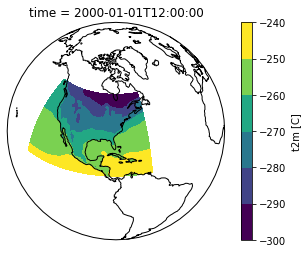

In [18]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))

subset_ds.t2m.isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

### Plot the first 9 time steps in a panel plot with a single colorbar using xarray's plot function.

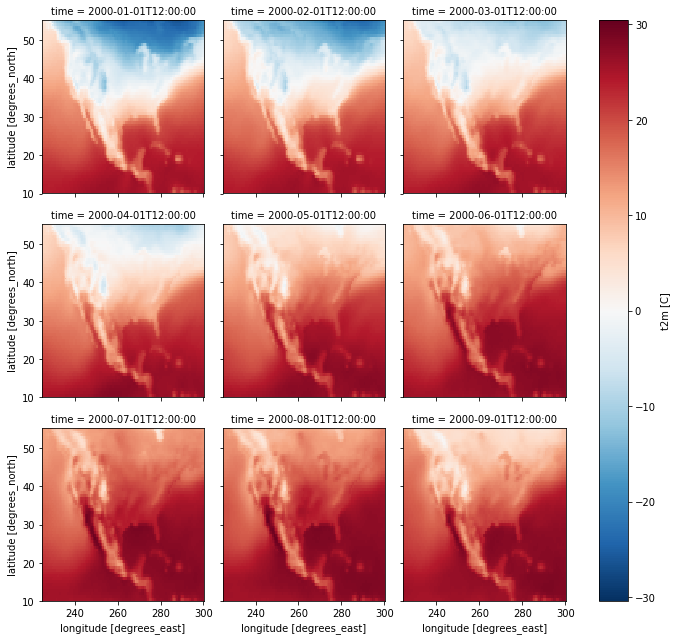

In [6]:
g_simple = subset_ds.t2m[:9].plot(x='longitude', y='latitude', col='time', col_wrap=3)

### Plot the first 9 time steps in a panel plot with a single colorbar using cartopy and save the figure.

t2m_panel_plot.png


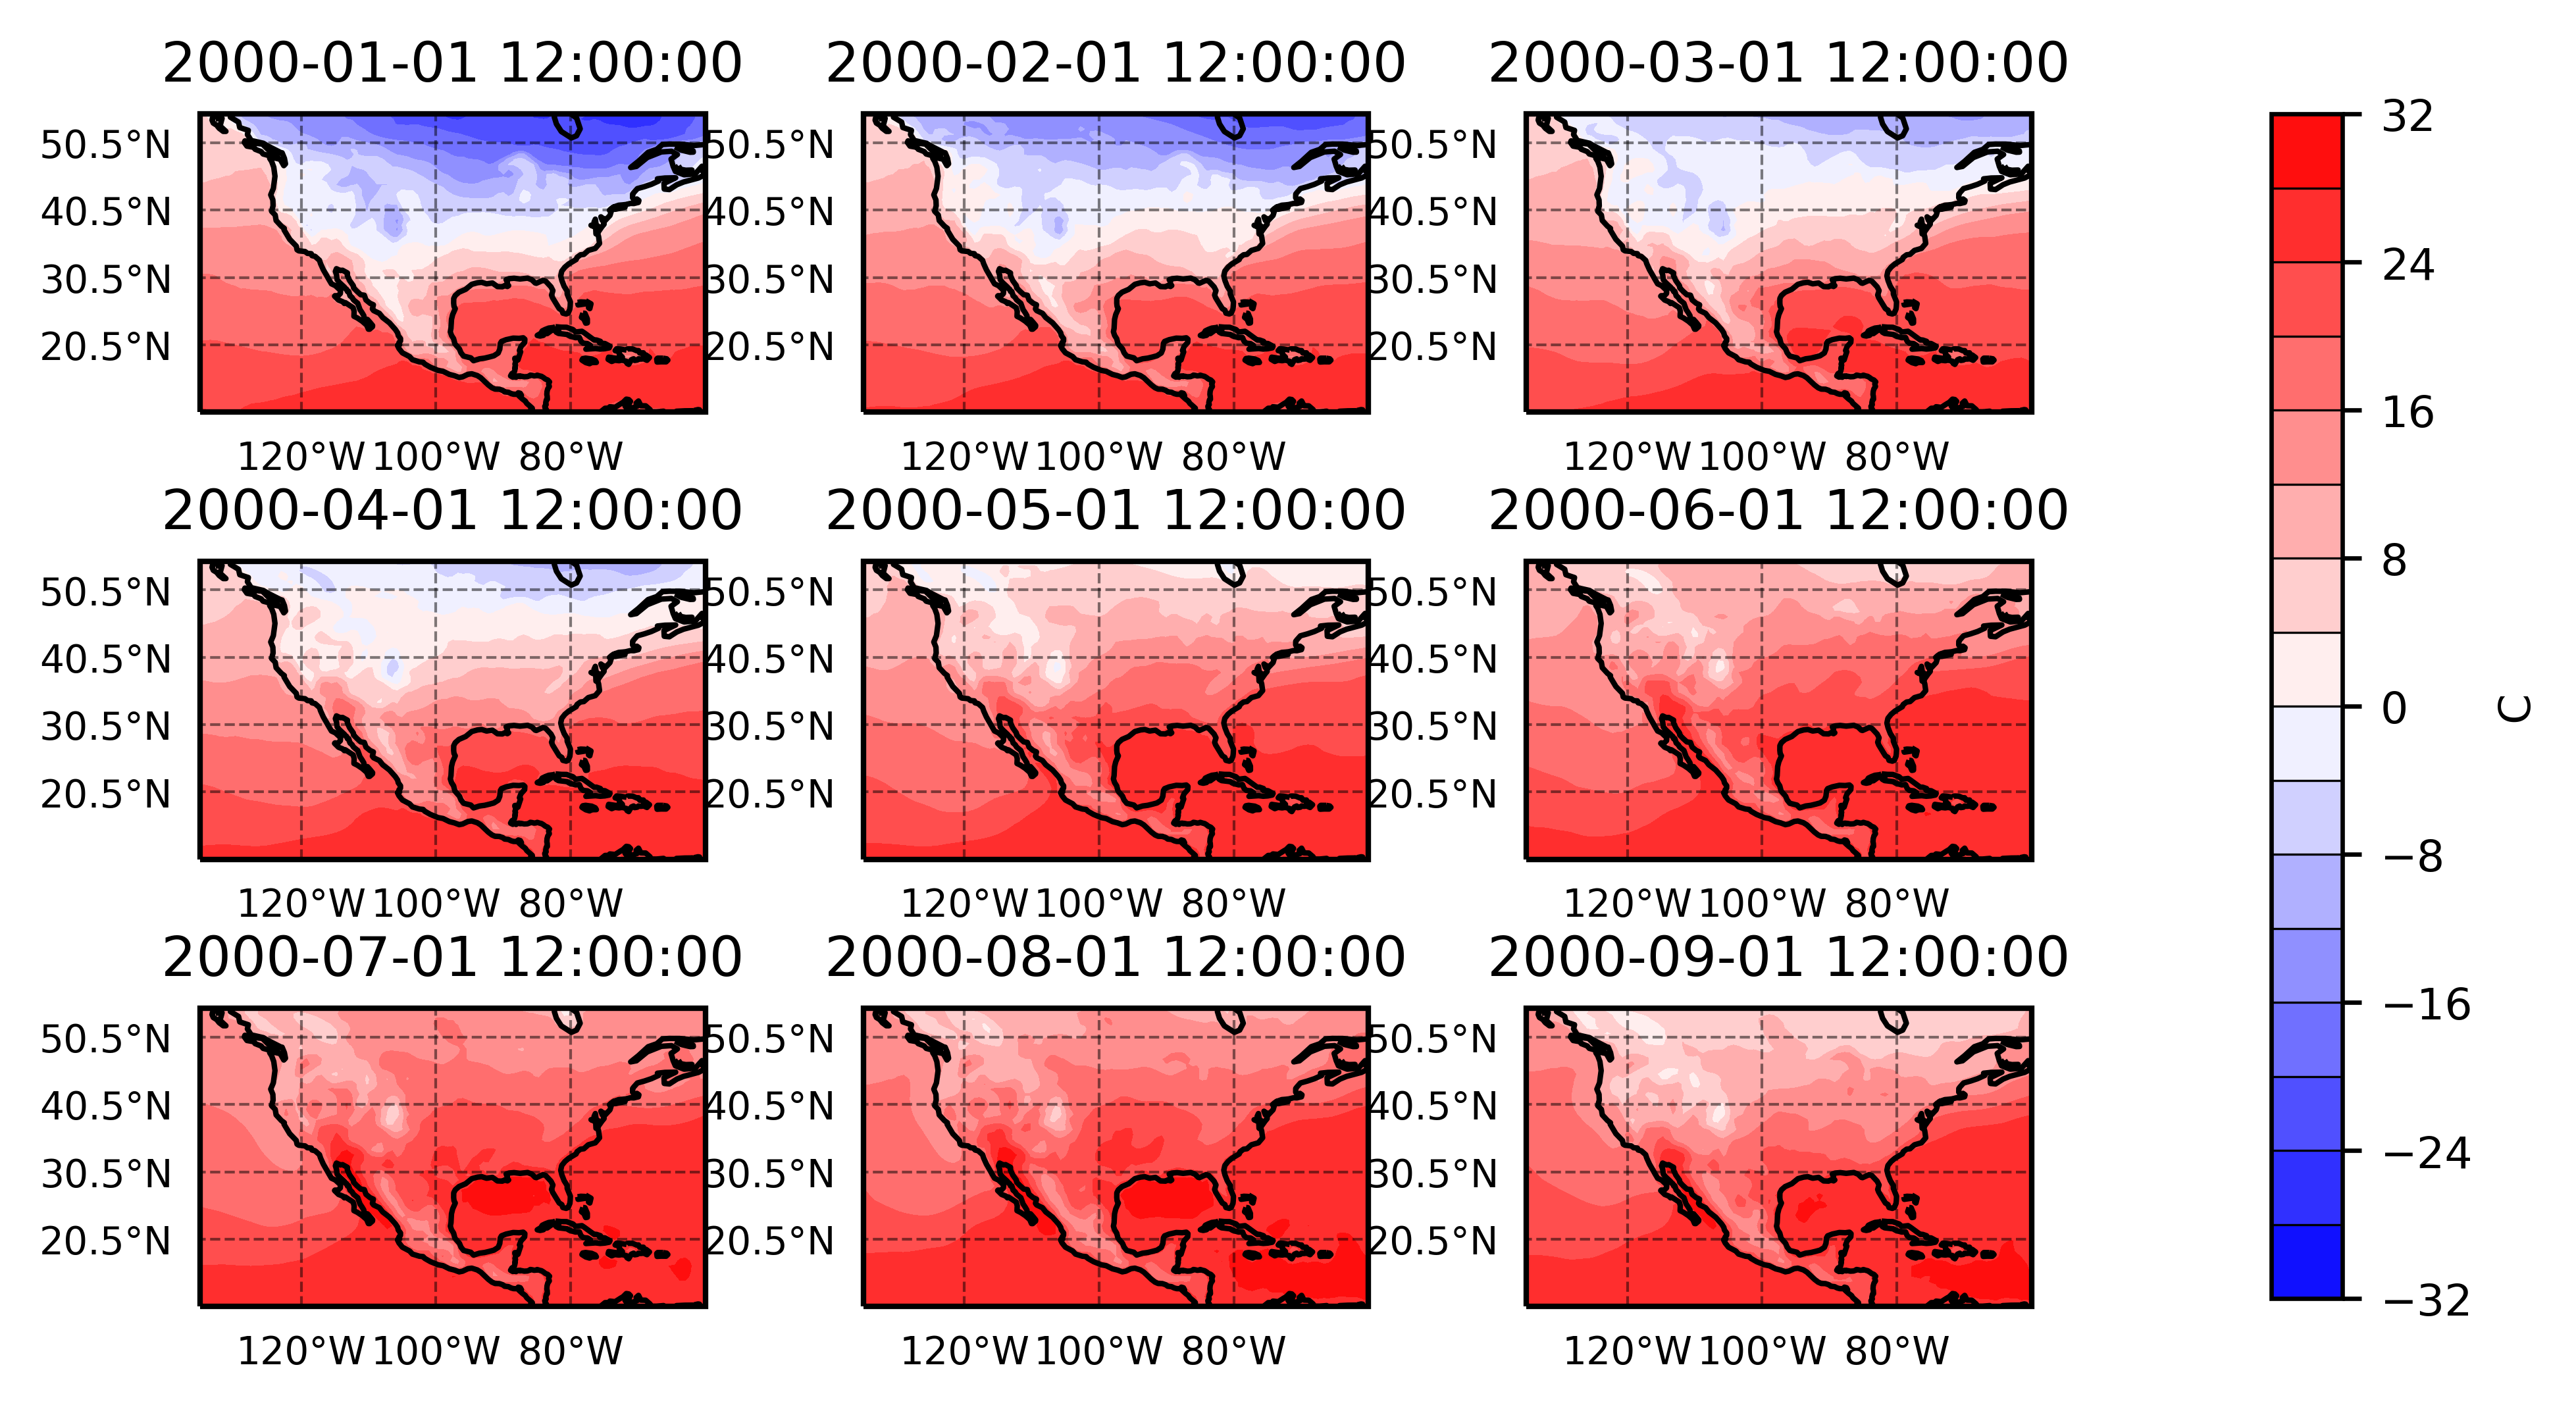

<Figure size 3600x2400 with 0 Axes>

In [7]:
fig = plt.figure()
fig.dpi = 600
fname = 't2m_panel_plot'
fmt = 'png'
results = subset_ds.t2m[:9]
lats = subset_ds['latitude']
lons = subset_ds['longitude']

## currently this only works if you set the clevs manually
clevs = np.arange(-32,36,4)

for i in np.arange(len(results)):
    ax = plt.subplot(3, 3, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, results[i], transform=ccrs.PlateCarree(),
                     extend='neither', cmap='bwr', levels=clevs)
    
    ax.coastlines(linewidths=1.0)
    ax.set_title(pd.Timestamp(subset_ds.time[i].values), fontsize=10)

    ## Add in meridian and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.flip(np.arange(360-lons.max()-20, 360-lons.min()+20, 20)*-1))
    gl.ylocator = mticker.FixedLocator(np.arange(lats.min(), lats.max()+10, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

# # add colorbar [left, bottom, width, height]
ax2 = fig.add_axes([1.0, 0.13, 0.03, 0.75])
cbar = fig.colorbar(cf, cax=ax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto')
cbar.ax.tick_params(labelsize=8)
cbar.set_label(results.units, fontsize=8)

plt.subplots_adjust(hspace=0.5, wspace=0.3)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))